In [1]:
import os
import os.path as osp
import pandas as pd

In [2]:
path_raw_data = '/home/agaldran/Desktop/data/deepdr_data/'

In [91]:
csv_path = osp.join(path_raw_data, 'regular-fundus-validation/regular-fundus-validation.csv')
df = pd.read_csv(csv_path)
df.columns

Index(['patient_id', 'image_id', 'image_path', 'Overall quality',
       'left_eye_DR_Level', 'right_eye_DR_Level', 'patient_DR_Level',
       'Field definition', 'Field definition.1', 'Artifact'],
      dtype='object')

In [92]:
csv_path = osp.join(path_raw_data, 'regular-fundus-training/regular-fundus-training.csv')

In [93]:
df = pd.read_csv(csv_path)

In [94]:
df.head()

,patient_id,image_id,image_path,Overall quality,left_eye_DR_Level,right_eye_DR_Level,patient_DR_Level,Clarity,Field definition,Artifact
0,1,1_l1,\regular-fundus-training\1\1_l1.jpg,0,0.0,NaN,0,8,8,4
1,1,1_l2,\regular-fundus-training\1\1_l2.jpg,0,0.0,NaN,0,8,8,0
2,1,1_r1,\regular-fundus-training\1\1_r1.jpg,0,NaN,0.0,0,8,8,4
3,1,1_r2,\regular-fundus-training\1\1_r2.jpg,0,NaN,0.0,0,10,8,0
4,2,2_l1,\regular-fundus-training\2\2_l1.jpg,0,2.0,NaN,2,10,8,6


In [95]:
df.columns

Index(['patient_id', 'image_id', 'image_path', 'Overall quality',
       'left_eye_DR_Level', 'right_eye_DR_Level', 'patient_DR_Level',
       'Clarity', 'Field definition', 'Artifact'],
      dtype='object')

In [7]:
df = df.drop(['patient_id','Overall quality','patient_DR_Level',
              'Clarity', 'Field definition', 'Artifact'], axis=1)

In [8]:
df.left_eye_DR_Level.fillna(0, inplace=True)
df.right_eye_DR_Level.fillna(0, inplace=True)

In [9]:
df['dr'] = df['left_eye_DR_Level'] + df['right_eye_DR_Level']

In [10]:
df = df.drop(['left_eye_DR_Level','right_eye_DR_Level'], axis=1)

In [11]:
abs_path = [osp.join(path_raw_data, n.replace('\\','/')[1:]) for n in list(df.image_path) ]

In [12]:
df['abs_path']=abs_path
df = df.drop(['image_path'], axis=1)

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import io
from skimage.measure import regionprops, label
from skimage.filters import threshold_li

from PIL import Image
from torchvision import transforms as tr

tg_size = (512, 512)
rsz = tr.Resize(tg_size)
rsz_fov = tr.Resize(tg_size, interpolation=Image.NEAREST)

In [3]:
def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [4]:
from skimage.exposure import adjust_gamma as gamma
from skimage.transform import rescale
from utils.image_preprocessing import correct_illumination

In [17]:
im_list = df.abs_path

In [18]:
n = [nn for nn in im_list if '16_l2.jpg' in nn]
n

['/home/agaldran/Desktop/data/deepdr_data/regular-fundus-training/16/16_l2.jpg',
 '/home/agaldran/Desktop/data/deepdr_data/regular-fundus-training/116/116_l2.jpg',
 '/home/agaldran/Desktop/data/deepdr_data/regular-fundus-training/216/216_l2.jpg']

In [5]:
from skimage.color import rgb2hsv
from skimage.exposure import equalize_adapthist
from skimage.filters import threshold_minimum

In [6]:
from skimage import img_as_float

In [7]:
def get_circle(binary):
    regions = regionprops(binary.astype(int), coordinates='rc')
    bubble = regions[0]

    x0, y0 = bubble.centroid
    r = bubble.major_axis_length / 2.

    def cost(params):
        x0, y0, r = params
        coords = draw.circle(y0, x0, r, shape=binary.shape)
        template = np.zeros_like(binary)
        template[coords] = 1
        return -np.sum(template == binary)

    x0, y0, r = optimize.fmin(cost, (x0, y0, r), disp=False)

    return x0, y0, r

In [8]:
def create_circular_mask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [9]:
from skimage import draw
from scipy import optimize

In [10]:
def get_crops(im_name):
    im = Image.open(im_name)
    h,w = im.size
    rsz_1000 = tr.Resize([1000,1000])

    im_red = img_as_float(np.array(rsz_1000(im)))
    im_v = (im_red)[:,:, 1]**0.5
    thresh = threshold_minimum(im_v)

    binary = im_v > thresh   
    x0, y0, r = get_circle(binary)
    binary = create_circular_mask(binary.shape[0], binary.shape[1], (x0, y0), r)
    
    rsz_back =  tr.Resize([w,h], interpolation=Image.NEAREST)
    binary = np.array(rsz_back(Image.fromarray(binary)))
    
    label_img = label(binary)
    regions = regionprops(label_img)
    areas = [r.area for r in regions]
    largest_cc_idx = np.argmax(areas)

    fov = regions[largest_cc_idx]

    cropped = np.array(im)[fov.bbox[0]:fov.bbox[2], fov.bbox[1]: fov.bbox[3], :]
    
    return cropped, fov.filled_image

In [41]:
im_name = '/home/agaldran/Desktop/data/deepdr_data/regular-fundus-training/1/1_l2.jpg'

In [80]:
def simple_crop(im_name):
    im = Image.open(im_name)
    rsz_512 = tr.Resize(512)
    im_rsz = rsz_512(im)
    ctr_crop = tr.CenterCrop([512,512])
    return ctr_crop(im_rsz)

In [81]:
im_crop= simple_crop(im_name)

In [ ]:
rsz_512 = tr.Resize(512)
im_rsz = rsz_512(im)
im_rsz

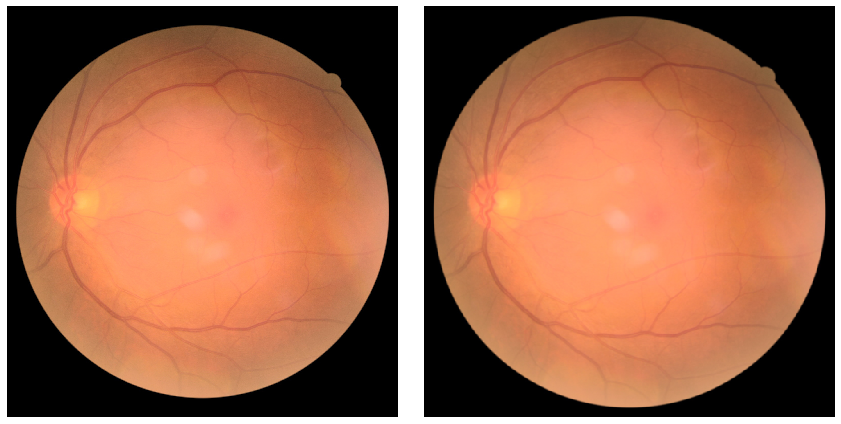

In [82]:
imshow_pair(im, im_crop)

In [74]:
im = Image.open(im_name)
h,w = im.size
rsz_1000 = tr.Resize([1000,1000])

im_red = img_as_float(np.array(rsz_1000(im)))
im_v = (im_red)[:,:, 1]**0.5
thresh = threshold_minimum(im_v)

binary = im_v > thresh   
x0, y0, r = get_circle(binary)
binary = create_circular_mask(binary.shape[0], binary.shape[1], (x0, y0), int(1.025*r))

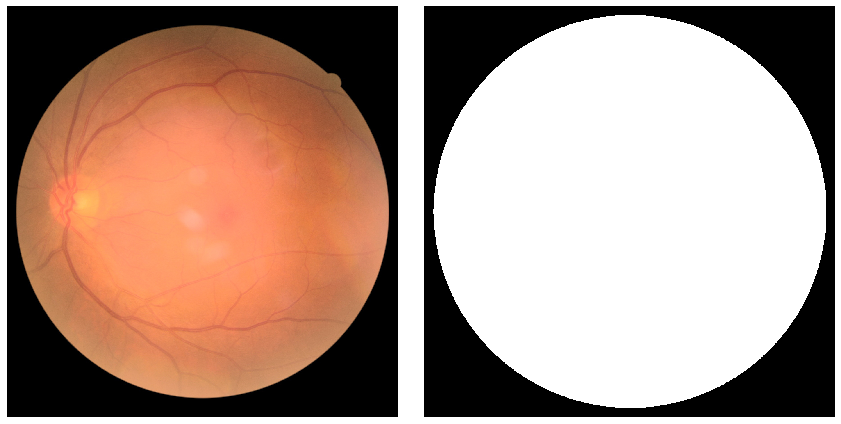

In [75]:
imshow_pair(im,binary)

In [71]:
label_img = label(binary)
regions = regionprops(label_img)
areas = [r.area for r in regions]
largest_cc_idx = np.argmax(areas)

fov = regions[largest_cc_idx]
cropped = np.array(im_red)[fov.bbox[0]:fov.bbox[2], fov.bbox[1]: fov.bbox[3], :]

In [72]:
cropped.shape, fov.filled_image.shape

((956, 956, 3), (956, 956))

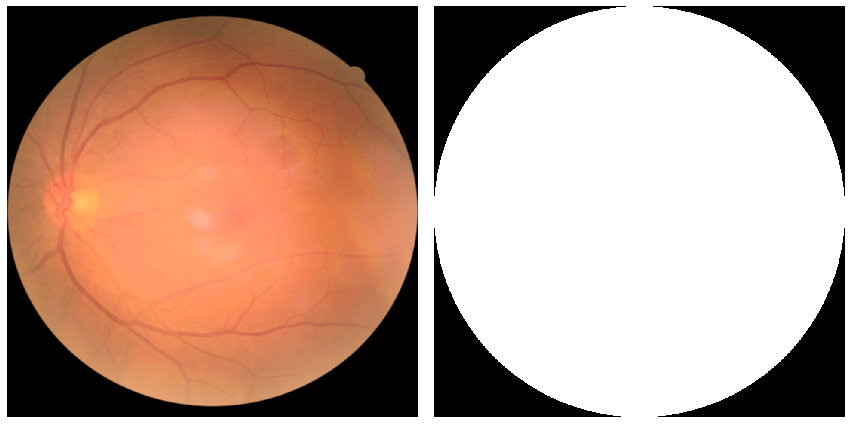

In [73]:
imshow_pair(cropped, fov.filled_image)

In [26]:
x,y =  get_crops(im_name)

In [27]:
x.shape, y.shape

((1700, 1619, 3), (1700, 1619))

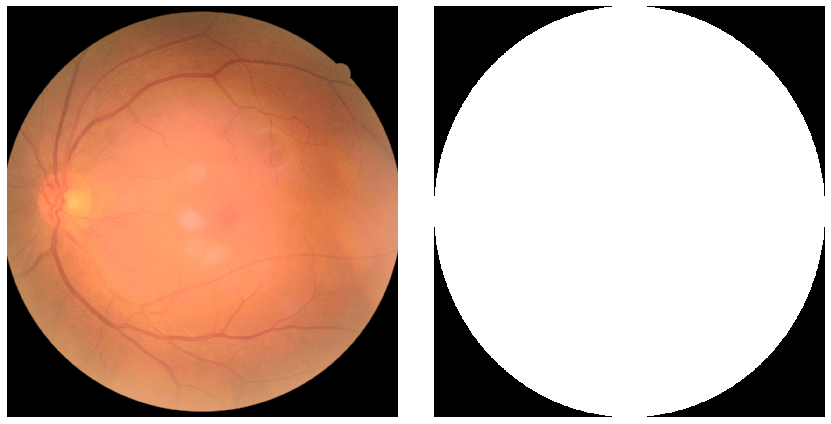

In [29]:
imshow_pair(x,y)

In [ ]:
path_out = 'data/images'

In [ ]:
image_ids = [osp.join(path_out, im_name.split('/')[-1]) for im_name in im_list]

In [ ]:
df['dr']=df['dr'].astype(int)

In [ ]:
df['image_id']=image_ids
df = df.drop(['abs_path'], axis=1)

In [ ]:
df['center'] = ['od' if '1.jpg' in n else 'mac' for n in list(df.image_id)]

In [ ]:
df_od = df[df.center=='od']
df_mac = df[df.center=='mac']

In [ ]:
df_od.drop(['center'], axis=1).to_csv('train_od.csv', index=False)
df_mac.drop(['center'], axis=1).to_csv('train_mac.csv', index=False)